## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於測試 類磁通估測器 的異常診斷成果 並輔以DWT 進行高頻處理 ###
### 2025 0730 ###



### 導入模型設定與套件 ###

In [92]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
np.random.seed(42)
random.seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 建立 LSTM 預測模型架構 ##
I2 in I2 out

### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

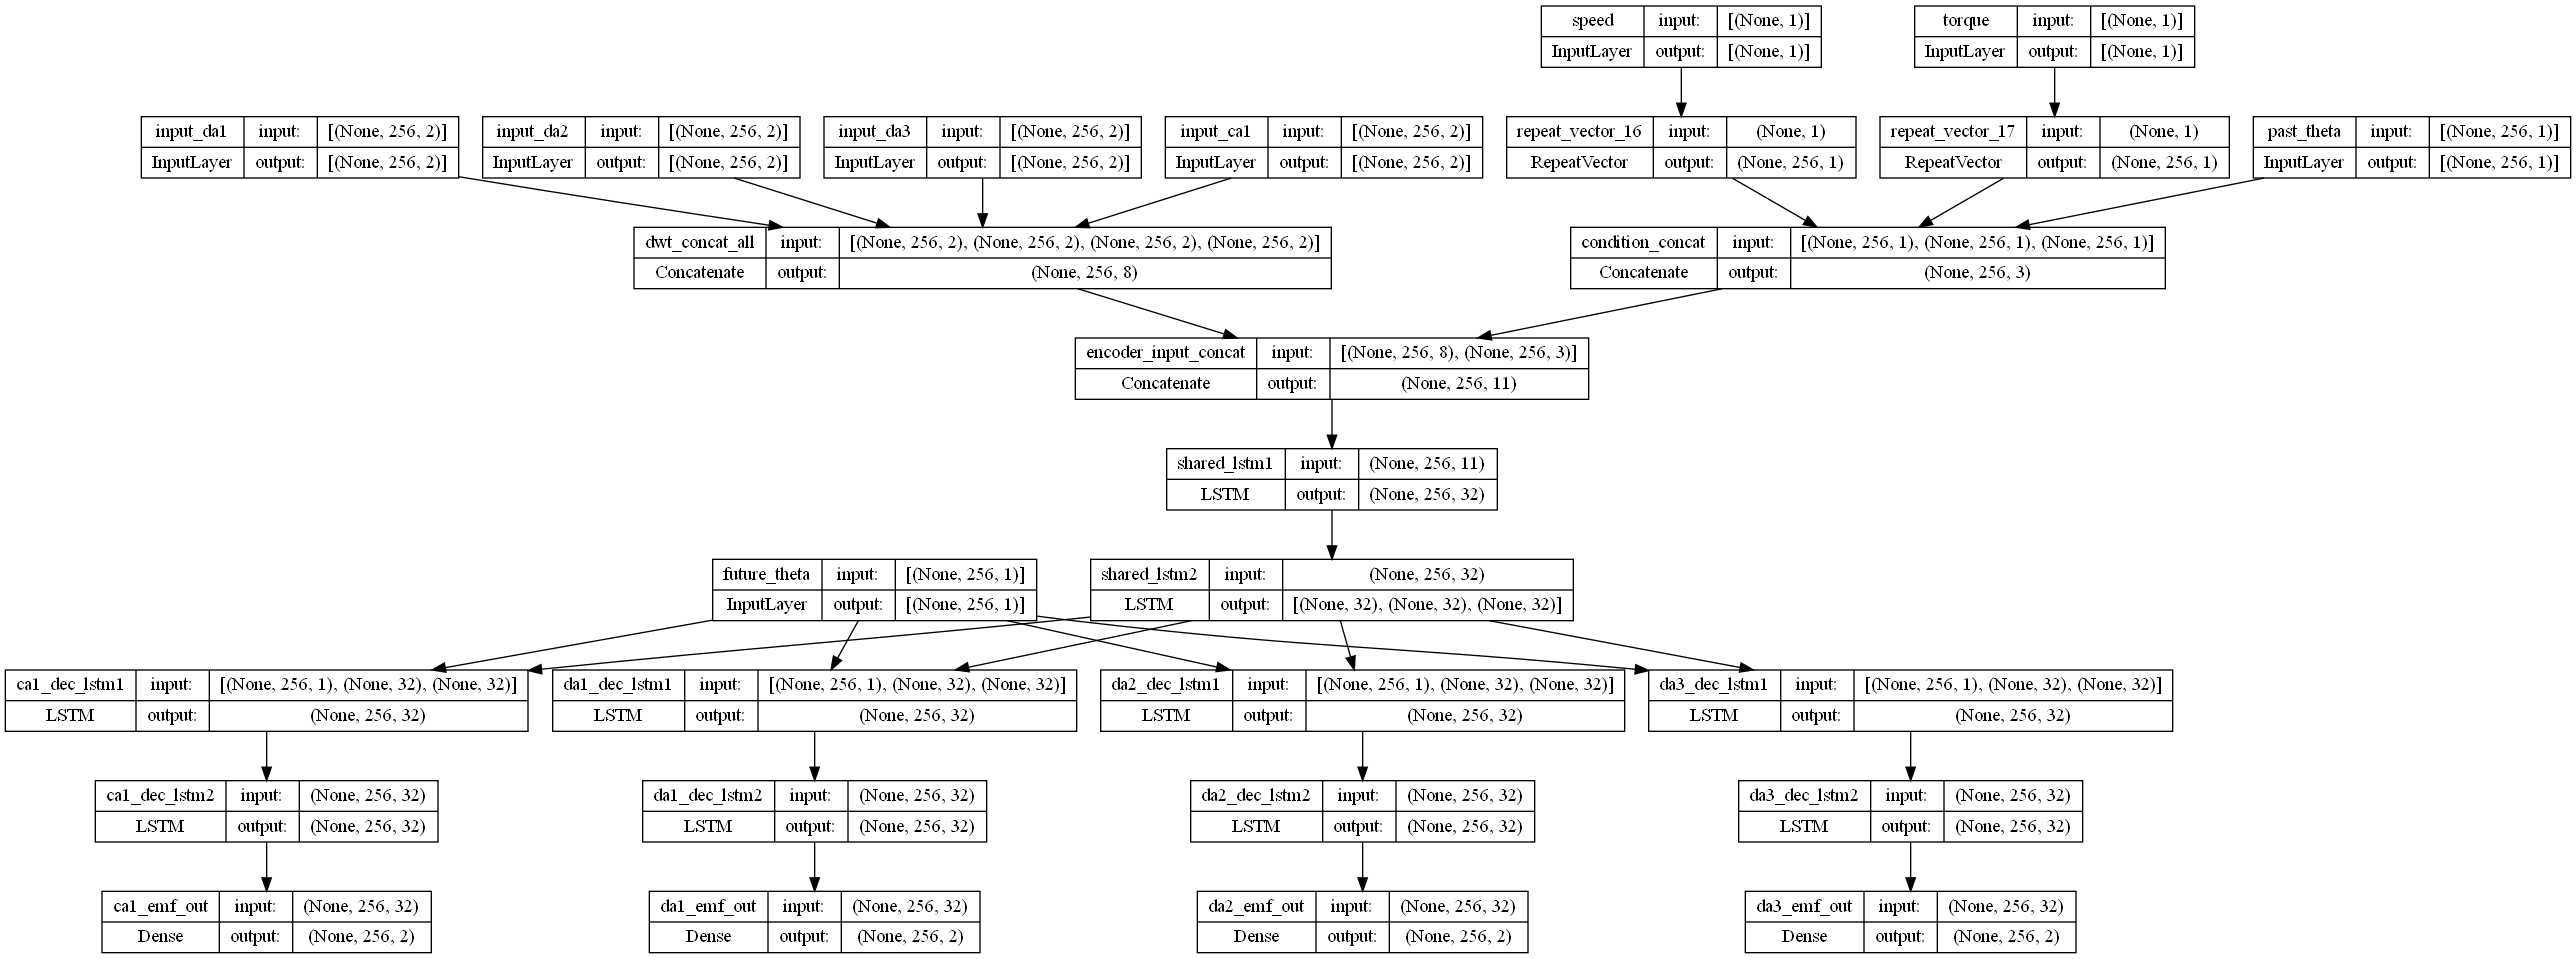

In [100]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K

# Initial model parameters
sequence_length=256
layer_number=1
future_length=256

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'CCAE_direct_lstm_DWT_emf_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

def build_dwt_lstm_shared_encoder_model(past_length=128, future_length=128, latent_dim=32):
    # === DWT 時序輸入（每層兩通道）===
    input_ca1 = Input(shape=(past_length, 2), name='input_ca1')
    input_da1 = Input(shape=(past_length, 2), name='input_da1')
    input_da2 = Input(shape=(past_length, 2), name='input_da2')
    input_da3 = Input(shape=(past_length, 2), name='input_da3')

    # === 條件資訊 ===
    speed = Input(shape=(1,), name='speed')                      
    torque = Input(shape=(1,), name='torque')                    
    past_theta = Input(shape=(past_length, 1), name='past_theta')  
    future_theta = Input(shape=(future_length, 1), name='future_theta')

    # === 重複條件資訊 ===
    speed_repeat = RepeatVector(past_length)(speed)
    torque_repeat = RepeatVector(past_length)(torque)

    # === 合併 DWT 分項與條件 ===
    dwt_concat = Concatenate(axis=-1, name='dwt_concat_all')([
        input_ca1, input_da1, input_da2, input_da3
    ])  # (None, past_length, 8) => 每個 time step 有 4 組 (2 channels) 合併

    cond_concat = Concatenate(name='condition_concat')([speed_repeat, torque_repeat, past_theta])  # (None, past_length, 3)

    encoder_input = Concatenate(name='encoder_input_concat')([dwt_concat, cond_concat])  # (None, past_length, 11)

    # === Shared LSTM Encoder ===
    x = LSTM(latent_dim, return_sequences=True, name='shared_lstm1')(encoder_input)
    _, h, c = LSTM(latent_dim, return_state=True, name='shared_lstm2')(x)

    # === 定義 Decoder 模組 ===
    def decoder_block(name):
        x_dec = LSTM(latent_dim, return_sequences=True, name=f'{name}_dec_lstm1')(future_theta, initial_state=[h, c])
        x_dec = LSTM(latent_dim, return_sequences=True, name=f'{name}_dec_lstm2')(x_dec)
        out = Dense(2, name=f'{name}_emf_out')(x_dec)
        return out

    # === 各 Decoder 分支輸出 ===
    out_ca1 = decoder_block("ca1")
    out_da1 = decoder_block("da1")
    out_da2 = decoder_block("da2")
    out_da3 = decoder_block("da3")

    # === 組裝模型 ===
    model = Model(
        inputs=[input_ca1, input_da1, input_da2, input_da3, speed, torque, past_theta, future_theta],
        outputs={
            'ca1_emf_out': out_ca1,
            'da1_emf_out': out_da1,
            'da2_emf_out': out_da2,
            'da3_emf_out': out_da3
        },
        name='DWT_LSTM_SharedEncoder_MultiDecoder'
    )

    return model
# build model 
my_model = build_dwt_lstm_shared_encoder_model(past_length=sequence_length, future_length=future_length, latent_dim=32)
my_model.compile(
    optimizer='adam',
    loss='mse',
)


metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

plot_model(my_model, to_file=os.path.join(model_path, model_name+'.png'), show_shapes=True, show_layer_names=True)


In [101]:

my_model.save(os.path.join(model_path, model_name + '.keras'))
test=load_model(os.path.join(model_path, model_name + '.keras'))
print("Model saved and loaded successfully.")
my_model.summary()
        

Model saved and loaded successfully.
Model: "DWT_LSTM_SharedEncoder_MultiDecoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 speed (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 torque (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 input_ca1 (InputLayer)         [(None, 256, 2)]     0           []                               
                                                                                                  
 input_da1 (InputLayer)         [(None, 256, 2)]     0           []                               
                           

### 資料前處理 ###

In [110]:

from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt
import pywt

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets'
Normal_data_path = os.path.join(NTU_dataset_path, 'Normal2')


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

def decompose_emf_signal(signal_1d, wavelet='db4', max_level=5):
    coeffs = pywt.wavedec(signal_1d, wavelet=wavelet, level=max_level)
    reconstructed = []
    for i in range(len(coeffs)):
        c = [np.zeros_like(c) if j != i else c.copy() for j, c in enumerate(coeffs)]
        r = pywt.waverec(c, wavelet=wavelet)
        reconstructed.append(r[:len(signal_1d)])  # 截斷長度
    return np.stack(reconstructed, axis=-1)  # shape: (length, level+1)

#變數宣告
Fs=20000
Rs=12.5
augmen_sample_number=1000

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V", "3000_0_1V", "3000_0_2V" ]  # 選擇特定資料夾
# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []
for folder in Normal_subfolders:
    parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
    # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
    
    if len(parquet_files) > 1:
        train, val = train_test_split(parquet_files, test_size=0.2)
       
        train_files.extend(train)
        val_files.extend(val)
    elif len(parquet_files) == 1:
        train_files.extend(parquet_files)


train_signals = []     # 將包含：emf(alpha, beta), current(alpha, beta), speed, torque
theta_array = []
speed_array_pu = []
torque_array = []

for file_path in train_files:
    if os.path.exists(file_path):
        df = read_rul_data(file_path)
        
        # === 原始電壓/電流輸入 ===
        va = np.array(df["Voltage alpha downsample"])
        vb = np.array(df["Voltage beta downsample"])
        ia = np.array(df["Current alpha downsample"])
        ib = np.array(df["Current beta downsample"])
        speed_rpm = df["Speed"][0]  # 單值
        torque = df["Torque avg"]  # 可為陣列或單值
        N = len(va)

        # === 計算 emf = (V - I*Rs)/omega ===
        omega = 2 * np.pi * speed_rpm / 60  # rad/s
        
        emf_a = (va - ia * Rs) / omega
        emf_b = (vb - ib * Rs) / omega
        
        
            # === 小波分解重建 ===
        emf_a_decomp = decompose_emf_signal(emf_a, wavelet='db4', max_level=5)  # shape: (N, 6)
        emf_b_decomp = decompose_emf_signal(emf_b, wavelet='db4', max_level=5)  # shape: (N, 6)

        # === 整合信號：原始 emf_a, emf_b, ia, ib + 小波重建 ===
        signal = np.concatenate([  # shape: (N, 4 + 6 + 6) = (N, 16)
        emf_a[:, None], 
        emf_b[:, None],
        ia[:, None],
        ib[:, None],
        emf_a_decomp, 
        emf_b_decomp
        ], axis=1)

        # === 增強樣本 ===
        augmented = data_random_augmentation(signal, sequence_length, augmen_sample_number, future_length)
        
        # === 計算角度 theta ===
        t = np.arange(sequence_length+future_length) / Fs  # 單位秒
        theta_segment = 2 * np.pi * speed_rpm / 60 * t  # radians
        theta_segment=np.repeat(theta_segment[None,:,None], repeats=augmen_sample_number, axis=0)
        # 儲存：信號、速度、扭矩
        train_signals.append(augmented)
        speed_array_pu.append(np.ones(augmented.shape[0]) * speed_rpm / 3000)
        torque_array.append(np.ones(augmented.shape[0]) * torque)
        theta_array.append(theta_segment)
        
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).reshape(-1, 1).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).reshape(-1, 1).astype(np.float32)
theta_array = np.concatenate(theta_array, axis=0).astype(np.float32)
print("theta_array shape:", theta_array.shape)

# 隨機打亂
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
speed_array_pu = speed_array_pu[indices]
torque_array = torque_array[indices]
# theta_array = theta_array[indices]

# 拆分時序資料
train_input_signals = train_signals[:, :sequence_length, :]   # 前段
train_fit_signals = train_signals[:, sequence_length:, :]     # 後段
past_theta= theta_array[:, :sequence_length, :]  # 前段角度
future_theta = theta_array[:, sequence_length:, :]  # 後段角度
# 拆分欄位（對應修改後的 signal 定義）
past_emf = train_input_signals[:, :, 0:2]
future_emf = train_fit_signals[:, :, 0:2]
past_current = train_input_signals[:, :, 2:4]
future_current = train_fit_signals[:, :, 2:4]


past_emf_decomp_alpha = train_input_signals[:, :, 4:10]  
future_emf_decomp_alpha = train_fit_signals[:, :, 4:10]  
past_emf_decomp_beta = train_input_signals[:, :, 10:16]  
future_emf_decomp_beta = train_fit_signals[:, :, 10:16]

dwt_inputs = [
    np.stack([past_emf_decomp_alpha[:, :, i], past_emf_decomp_beta[:, :, i]], axis=-1)
    for i in range(4)
]

dwt_outputs = {
    'ca1_emf_out': np.stack([future_emf_decomp_alpha[:, :, 0], future_emf_decomp_alpha[:, :, 0]], axis=-1),
    'da1_emf_out': np.stack([future_emf_decomp_alpha[:, :, 1], future_emf_decomp_alpha[:, :, 1]], axis=-1),
    'da2_emf_out': np.stack([future_emf_decomp_alpha[:, :, 2], future_emf_decomp_alpha[:, :, 2]], axis=-1),
    'da3_emf_out': np.stack([future_emf_decomp_alpha[:, :, 3], future_emf_decomp_alpha[:, :, 3]], axis=-1)
}

current_diff_array = np.diff(train_input_signals[:, :, 2:4], axis=1, prepend=0)

print("emf_past shape:", past_emf.shape)
print("future_emf shape:", future_emf.shape)
print("past_theta shape:", past_theta.shape)
print("future_theta shape:", future_theta.shape)
print("current_diff_array shape:", current_diff_array.shape)
print("speed_array_pu shape:", speed_array_pu.shape)
print("torque_array shape:", torque_array.shape)
print("theta_array sahpe:", theta_array.shape)


theta_array shape: (60000, 512, 1)
emf_past shape: (60000, 256, 2)
future_emf shape: (60000, 256, 2)
past_theta shape: (60000, 256, 1)
future_theta shape: (60000, 256, 1)
current_diff_array shape: (60000, 256, 2)
speed_array_pu shape: (60000, 1)
torque_array shape: (60000, 1)
theta_array sahpe: (60000, 512, 1)


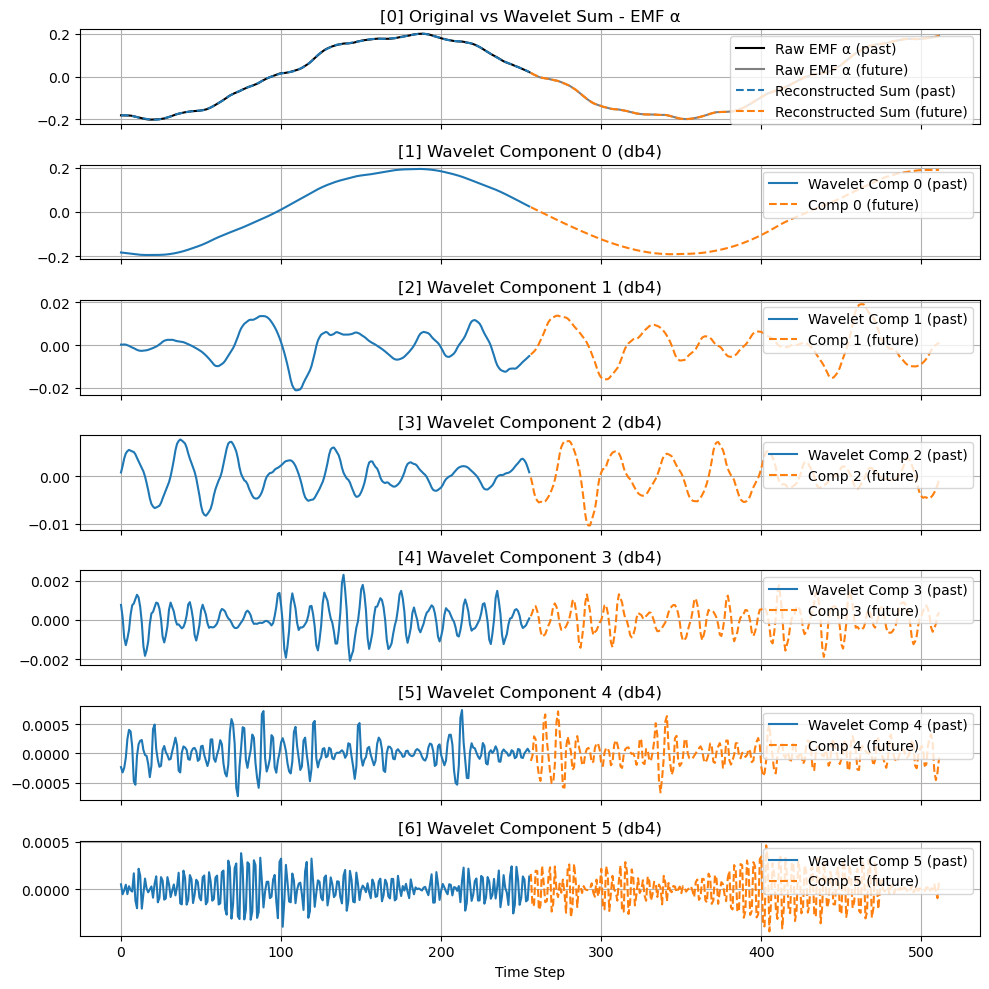

In [103]:
import matplotlib.pyplot as plt
import numpy as np

ceck_idx = 151
n_levels = 6

# 擷取資料
raw_past = past_emf[ceck_idx, :, 0]  # 原始 emf alpha（過去段）
raw_future = future_emf[ceck_idx, :, 0]

wavelet_past = past_emf_decomp_alpha[ceck_idx, :, :]   # shape = (seq_len, 6)
wavelet_future = future_emf_decomp_alpha[ceck_idx, :, :]

# 總和（所有層相加）
wavelet_past_sum = np.sum(wavelet_past[:,0:3], axis=-1)
wavelet_future_sum = np.sum(wavelet_future, axis=-1)

# === 畫圖 ===
fig, axes = plt.subplots(n_levels + 1, 1, figsize=(10, 10), sharex=True)

time_past = np.arange(sequence_length)
time_future = np.arange(sequence_length, sequence_length + future_length)

# 第0個子圖：原始 vs 重建總和
axes[0].plot(time_past, raw_past, label='Raw EMF α (past)', color='black')
axes[0].plot(time_future, raw_future, label='Raw EMF α (future)', color='gray')
axes[0].plot(time_past, wavelet_past_sum, label='Reconstructed Sum (past)', linestyle='--')
axes[0].plot(time_future, wavelet_future_sum, label='Reconstructed Sum (future)', linestyle='--')
axes[0].set_title(f'[0] Original vs Wavelet Sum - EMF α')
axes[0].legend(loc='upper right')
axes[0].grid(True)

# 第1~6個子圖：各層分解
for i in range(n_levels):
    axes[i + 1].plot(time_past, wavelet_past[:, i], label=f'Wavelet Comp {i} (past)')
    axes[i + 1].plot(time_future, wavelet_future[:, i], linestyle='--', label=f'Comp {i} (future)')
    axes[i + 1].set_title(f'[{i+1}] Wavelet Component {i} (db4)')
    axes[i + 1].legend(loc='upper right')
    axes[i + 1].grid(True)

plt.xlabel("Time Step")
plt.tight_layout()
plt.show()


### 物理模型擬合 ###

### 模型訓練 ###

Model structure passed, start training...
GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Epoch 1/20
422/422 [==============================] - 56s 119ms/step - loss: 0.0103 - ca1_emf_out_loss: 0.0191 - da1_emf_out_loss: 4.7290e-04 - da2_emf_out_loss: 3.6348e-04 - da3_emf_out_loss: 4.2352e-05 - val_loss: 0.0020 - val_ca1_emf_out_loss: 0.0190 - val_da1_emf_out_loss: 2.1976e-05 - val_da2_emf_out_loss: 5.3773e-06 - val_da3_emf_out_loss: 6.1328e-07 - lr: 0.0010
Epoch 2/20
422/422 [==============================] - 49s 116ms/step - loss: 0.0020 - ca1_emf_out_loss: 0.0175 - da1_emf_out_loss: 2.1491e-05 - da2_emf_out_loss: 5.0713e-06 - da3_emf_out_loss: 1.7436e-06 - val_loss: 0.0016 - val_ca1_emf_out_loss: 0.0143 - val_da1_emf_out_loss: 2.1727e-05 - val_da2_emf_out_loss: 4.9365e-06 - val_da3_emf_out_loss: 5.9861e-07 - lr: 0.0010
Epoch 3/20
422/422 [==============================] - 47s 112ms/step - loss: 0.0014 - ca1_emf_out_loss: 0.0121 - da1_emf_out_loss:

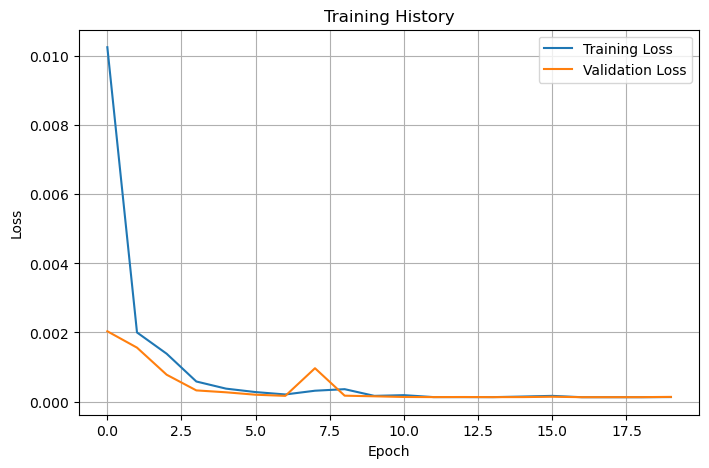

In [104]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# my_model.predict([dwt_inputs[0], speed_array_pu[0:1,:], torque_array[0:1,:], past_theta[0:1,:,:], future_theta[0:1,:,:]])

print("Model structure passed, start training...")

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU devices found:")
for gpu in gpus:
    print(gpu)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


my_model.compile(
    optimizer='adam',
    loss={
        'ca1_emf_out': 'mse',
        'da1_emf_out': 'mse',
        'da2_emf_out': 'mse',
        'da3_emf_out': 'mse'
    },
    loss_weights={
        'ca1_emf_out': 0.1,
        'da1_emf_out': 1.0,
        'da2_emf_out': 10.0,
        'da3_emf_out': 100.0
    }
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 加入 EarlyStopping（恢復最佳權重）
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,           # 若 val_loss 連續5次沒有改善，就停止訓練
    restore_best_weights=True,
    verbose=1
)

history = my_model.fit(
    x=dwt_inputs + [speed_array_pu, torque_array, past_theta, future_theta],
    y=dwt_outputs,
    batch_size=128,
    epochs=20,
    validation_split=0.1, 
    callbacks=[lr_scheduler, early_stop] 
)

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name,
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_date":  datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}
with open(os.path.join(model_path, model_name + '_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

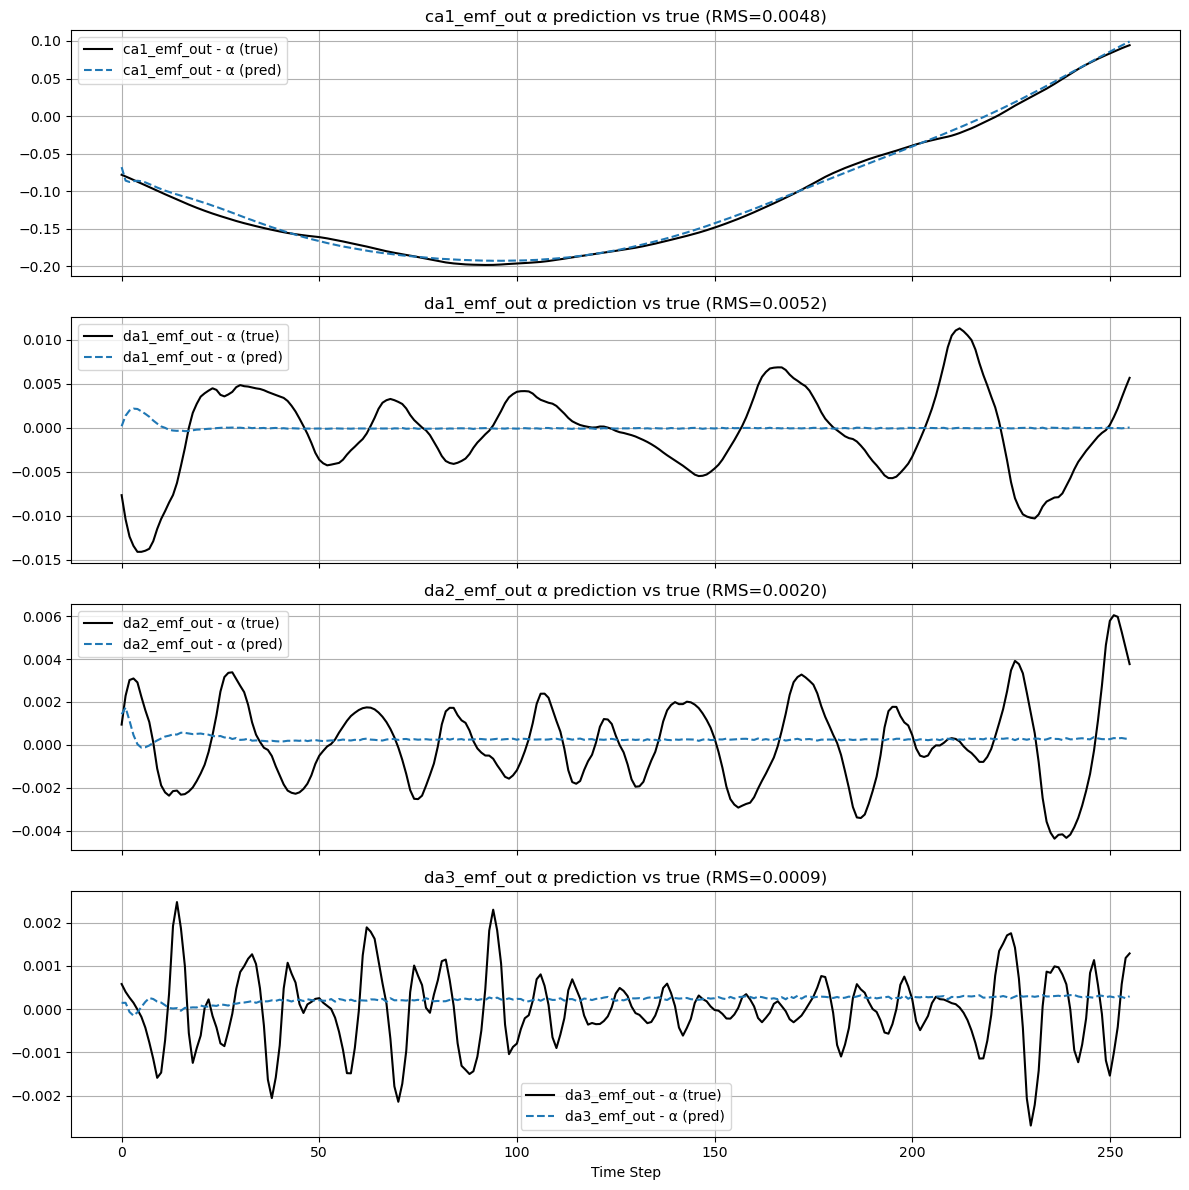

In [113]:
# 取出第0筆的每個 DWT 分支輸入
test_x = [inp[0:1] for inp in dwt_inputs]  # 取 batch 中第 0 筆，每個 shape: (1, past_len, 2)

# 取出條件輸入
speed_test = speed_array_pu[0:1]
torque_test = torque_array[0:1]
past_theta_test = past_theta[0:1]
future_theta_test = future_theta[0:1]
# 進行單筆推論
y_pred_dict = my_model.predict(
    test_x + [speed_test, torque_test, past_theta_test, future_theta_test],
    verbose=0
)
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)
output_names = ['ca1_emf_out', 'da1_emf_out', 'da2_emf_out', 'da3_emf_out']

for i, name in enumerate(output_names):
    y_pred = y_pred_dict[name][0, :, 0]  # 取 α 分量
    y_true = dwt_outputs[name][0, :, 0]
    axes[i].plot(y_true, label=f'{name} - α (true)', color='black')
    axes[i].plot(y_pred, label=f'{name} - α (pred)', linestyle='--')
    error = y_pred - y_true
    rms = np.sqrt(np.mean(error**2))
    axes[i].set_title(f'{name} α prediction vs true (RMS={rms:.4f})')
    axes[i].legend()
    axes[i].grid(True)

plt.xlabel('Time Step')
plt.tight_layout()
plt.show()


### 驗證結果 ###

Train input signals shape: (60000, 256, 16)
1/1 [==============================] - 0s 118ms/step


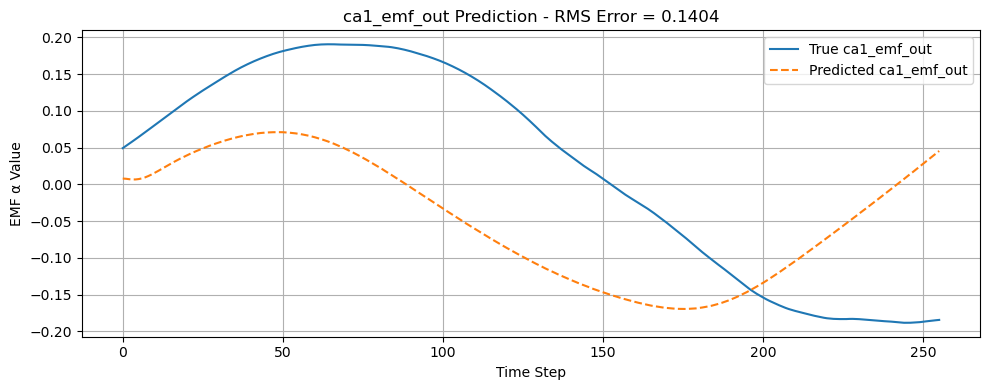

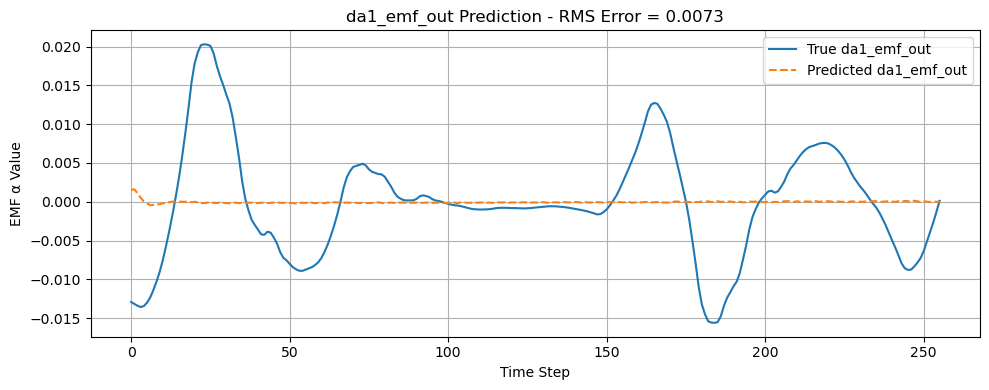

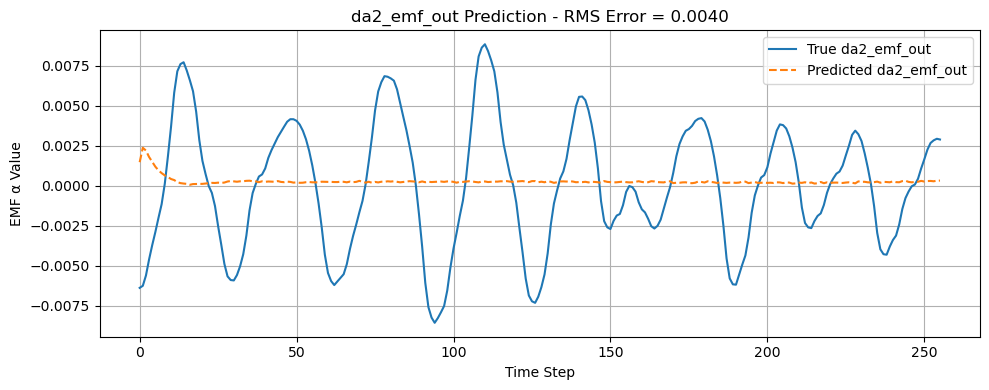

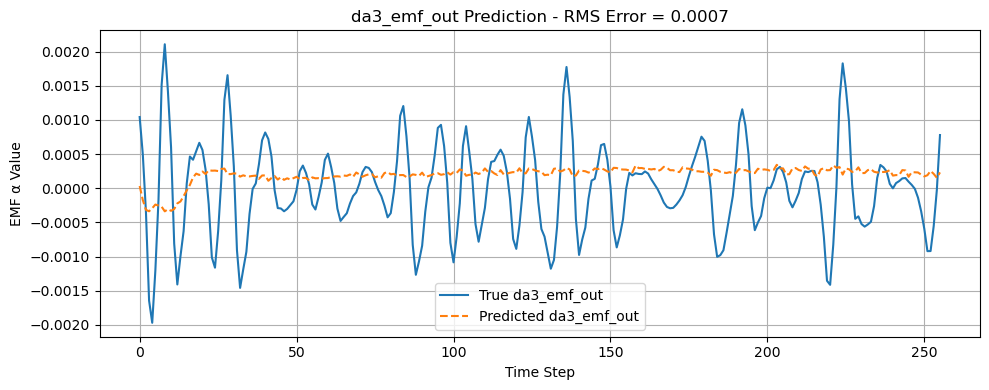

In [106]:
print(f"Train input signals shape: {train_input_signals.shape}")
# print(x_128.shape)
# === 載入測試資料 ===

# selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_5.parquet"
# testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_1800_1_0V\RUL_Data_3_4.parquet"
test_data = read_rul_data(testfile)
start_idx=112

# === 準備輸入 ===
# 分解前 4 層，αβ 合併為 shape=(1, past_len, 2)
test_past_alpha = np.stack([
    test_data["Voltage alpha downsample"][:sequence_length],
    test_data["Current alpha downsample"][:sequence_length]
], axis=-1)

test_past_beta = np.stack([
    test_data["Voltage beta downsample"][:sequence_length],
    test_data["Current beta downsample"][:sequence_length]
], axis=-1)

# 計算 emf = (v - i*Rs)/ω
omega = 2 * np.pi * test_data["Speed"][0] / 60
emf_alpha = (test_past_alpha[:, 0] - test_past_alpha[:, 1] * Rs) / omega
emf_beta = (test_past_beta[:, 0] - test_past_beta[:, 1] * Rs) / omega

# 小波分解
def get_wavelet_inputs(signal, level=4):
    import pywt
    coeffs = pywt.wavedec(signal, wavelet='db4', level=level)
    recons = []
    for i in range(level):
        c = [np.zeros_like(c) if j != i+1 else c.copy() for j, c in enumerate(coeffs)]
        rec = pywt.waverec(c, wavelet='db4')[:len(signal)]
        recons.append(rec)
    return recons  # list of (len,)

alpha_bands = get_wavelet_inputs(emf_alpha)
beta_bands = get_wavelet_inputs(emf_beta)

# === 構建模型輸入（前4層） ===
dwt_inputs_test = [
    np.stack([alpha_bands[i], beta_bands[i]], axis=-1)[None, :, :]  # shape: (1, past_len, 2)
    for i in range(4)
]

# 條件變數
speed = (test_data["Speed"][0] / 3000).astype(np.float32)
torque = (test_data["Torque avg"]).astype(np.float32)

time_all = np.arange(sequence_length + future_length) / Fs
theta_all = omega * time_all
past_theta = theta_all[:sequence_length, None]
future_theta_ = theta_all[sequence_length:sequence_length+future_length, None]

# === 單筆預測 ===
y_pred_dict = my_model.predict(
    dwt_inputs_test + [
        np.array([[speed]]), 
        np.array([[torque]]), 
        past_theta[None, :, :],
        future_theta_[None, :, :]
    ]
)

# === 真實值對齊（每個輸出都對應 α 的未來第 i 層）===
true_outputs = {
    'ca1_emf_out': future_emf_decomp_alpha[0:1, :, 0],
    'da1_emf_out': future_emf_decomp_alpha[0:1, :, 1],
    'da2_emf_out': future_emf_decomp_alpha[0:1, :, 2],
    'da3_emf_out': future_emf_decomp_alpha[0:1, :, 3],
}

# === 繪圖每個輸出 ===
for key in y_pred_dict:
    pred = y_pred_dict[key][0, :, 0]  # 取 α 分量
    true = true_outputs[key][0]
    residual = pred - true
    rms = np.sqrt(np.mean(residual**2))

    plt.figure(figsize=(10, 4))
    plt.plot(true, label=f'True {key}')
    plt.plot(pred, linestyle='--', label=f'Predicted {key}')
    plt.title(f'{key} Prediction - RMS Error = {rms:.4f}')
    plt.xlabel('Time Step')
    plt.ylabel('EMF α Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Second Part 同架構改純電流 ###

In [107]:
# from datetime import datetime
# import json
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
# from tensorflow.keras import backend as K


# model_folder_path = r'NTU_rul_models\time_series_models'
# model_current_name = f'CCAE_direct_lstm_multiscale_Current_Base{sequence_length}Future{future_length}'
# model_current_path = os.path.join(model_folder_path, model_name)
# os.makedirs(model_path, exist_ok=True)

# # === 所有 Lambda 替代函數 ===

# def get_past_input_theta(x, past_length):
#     return x[:, :past_length, :]

# def get_future_input_theta(x, future_length):
#     return x[:, future_length:, :]

# def slice_quarter_fn(x):
#     return x[:, -x.shape[1] // 4:, :]

# def slice_half_fn(x):
#     return x[:, -x.shape[1] // 2:, :]

# def fusion_fn(x):
#     return (x[0] + x[1] + x[2]) / 3.0


# def build_multiscale_lstm_fusion_model_current(past_length=128, future_length=128, latent_dim=32):
    
#     # === 輸入 ===
#     past_input_current = Input(shape=(past_length, 2), name='past_input_emf')
#     input_all_theta = Input(shape=(past_length + future_length, 1), name='past_input_all_theta')

#     # 替代 lambda 使用 Lambda + 自定義函式（注意使用 arguments 傳參數）
#     past_input_theta = Lambda(get_past_input_theta, arguments={'past_length': past_length}, name='past_input')(input_all_theta)
#     future_input_theta = Lambda(get_future_input_theta, arguments={'future_length': future_length}, name='future_input')(input_all_theta)

#     # 合併過去序列
#     # 合併過去序列
#     past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_current, past_input_theta])
    
#     # 多尺度切片（具名函式取代 Lambda）
#     x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
#     x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
#     x_all = past_input_all

#     # === Decoder 分支（含 Conv1D 殘差） ===
#     def decoder_branch(x_in, name):
#         _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
#         x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_input_theta, initial_state=[h, c])
#         # Conv1D 濾出局部變化（不做殘差）
#         # x = Conv1D(32, kernel_size=3, padding='same', activation='relu', name=f"{name}_conv")(x)
#         return Dense(2, name=f"{name}_out")(x)

#     out_64 = decoder_branch(x_quarter, "net64")
#     out_96 = decoder_branch(x_half, "net96")
#     out_128 = decoder_branch(x_all, "net128")
    
#     # === 融合：學習式 softmax 加權平均 ===
#     def fusion_block(out_list, name="fusion"):
#         # 拼接所有輸出 (B, T, 6)
#         concat = Concatenate(name=f"{name}_concat")(out_list)
#         # 計算每個分支的 softmax 權重 (B, T, 3)
#         fusion_weights = Dense(3, activation='softmax', name=f"{name}_weights")(concat)
#         fusion_weights = Lambda(lambda x: tf.expand_dims(x, axis=-1), name=f"{name}_expand")(fusion_weights)  # (B, T, 3, 1)

#         # 堆疊預測值 (B, T, 3, 2)
#         pred_stack = Lambda(lambda x: tf.stack(x, axis=-2), name=f"{name}_stack")(out_list)

#         # 權重相乘 + 求和
#         weighted = Multiply(name=f"{name}_multiply")([fusion_weights, pred_stack])  # (B, T, 3, 2)
#         fused = Lambda(lambda x: tf.reduce_sum(x, axis=-2), name=f"{name}_output")(weighted)  # (B, T, 2)
#         return fused
    
#     # === 融合：簡單平均（取代學習式 softmax） ===
#     output_emf = Lambda(fusion_fn, name="fusion_output")([out_64, out_96, out_128])

#     model = Model(
#         inputs=[past_input_current, past_input_theta, future_input_theta],
#         outputs=[output_emf],
#         name="MSSW_LSTM_MultiTask3"
#     )

#     return model

# # build model 
# my_model_current = build_multiscale_lstm_fusion_model_current(past_length=sequence_length, future_length=future_length, latent_dim=128)
# my_model_current.compile(optimizer='adam', loss='mse')
# metadata = {
#     "model_name": model_name,
#     "sequence_length": sequence_length,
#     "layer_number": layer_number,
#     "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#     "trained": False,
#     "train_date": None,
# }
# with open(os.path.join(model_current_path, model_current_name + '_metadata.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# plot_model(my_model_current, to_file=os.path.join(model_current_path, model_current_name+'.png'), show_shapes=True, show_layer_names=True)

# my_model_current.predict([train_input_signals[0:1,:,-2:], past_theta[0:1,:,:], future_theta[0:1,:,:]])
# print("Model structure passed, start training...")

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print("GPU devices found:")
# for gpu in gpus:
#     print(gpu)
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )

# # 加入 EarlyStopping（恢復最佳權重）
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,           # 若 val_loss 連續5次沒有改善，就停止訓練
#     restore_best_weights=True,
#     verbose=1
# )

# history = my_model_current.fit(
#     x=[train_input_signals[:,:,-2:], past_theta, future_theta], 
#     y=train_fit_signals[:,:,:2],
#     batch_size=128,
#     epochs=20,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler, early_stop] 
# )

# plt.figure(figsize=(8, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# if 'val_loss' in history.history:
#     plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training History')
# plt.legend()
# plt.grid(True)
# plt.show()

# metadata = {
#     "model_name": model_current_name,
#     "sequence_length": sequence_length,
#     "layer_number": layer_number,
#     "trained": True,
#     "train_date":  datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
# }
# with open(os.path.join(model_path, model_current_name + '_metadata.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# print(f"Train input signals shape: {train_input_signals.shape}")
# # print(x_128.shape)
# # === 載入測試資料 ===

# # selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
# testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_2.parquet"
# # testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_1800_1_0V\RUL_Data_3_4.parquet"
# test_data = read_rul_data(testfile)
# start_idx=112

# # V/I歷史輸入與未來電壓
# past_vi = np.stack([
#     test_data["Voltage alpha downsample"][:sequence_length],
#     test_data["Voltage beta downsample"][:sequence_length],
#     test_data["Current alpha downsample"][:sequence_length],
#     test_data["Current beta downsample"][:sequence_length]
# ], axis=1)  # shape (128, 4)
# past_vi=np.expand_dims(past_vi, axis=0).astype(np.float32)


# speed_current_past = np.stack([
#     test_data["Current alpha downsample"][:sequence_length]* test_data["Speed"][0]/3000,   
#     test_data["Current beta downsample"][:sequence_length]* test_data["Speed"][0]/3000
# ], axis=1)  # shape (128, 2)
# speed_current_past = np.expand_dims(speed_current_past, axis=0).astype(np.float32)  # (1, 128, 2)

# x_future = np.stack([
#     test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length],
#     test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]
# ], axis=1)
# x_future=np.expand_dims(x_future, axis=0).astype(np.float32)  # (1, 128, 2)

# true_future_current = np.stack([
#     test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
#     test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
# ], axis=1)


# past_emf=(past_voltage-past_current*Rs)/(speed*3000/60*2*np.pi)  # 計算電動勢
# time_stamp_all = np.arange(0, sequence_length + future_length,1)/Fs  # shape: (time_length,)
# theta_all_rad = speed * 3000 / 60 * 2 *np.pi* time_stamp_all 
# past_theta = theta_all_rad[:sequence_length, None]  # 取前 sequence_length 個時間步長
# future_theta = theta_all_rad[sequence_length:sequence_length+future_length, None]

# # 確認資料形狀
# # 印出輸入變數名稱與形狀
# print(f"past_vi shape: {past_vi.shape}")
# print(f"speed_current_past shape: {speed_current_past.shape}")
# print(f"x_future shape: {x_future.shape}")
# print(f"speed shape: {speed.shape}")
# print(f"torque shape: {torque.shape}")
# print(f"past_current shape: {past_current.shape}")  
# print(f"current_diff_past shape: {current_diff_past.shape}  ")
  
  
# # === 預測 ===
# y_future_pred = my_model_current.predict([
#     past_vi[:,:,-2:], 
#     past_theta[None, :], 
#     future_theta[None, :]
# ])
# print(len(y_future_pred))
# y_future_pred=y_future_pred[0]  # 去掉 batch 維度


# # === 繪圖：歷史 + 未來預測 ===
# plt.figure(figsize=(10, 5))
# plt.plot(range(sequence_length), past_current[:, 0], color='black', label='True emf Alpha (history)')
# plt.plot(range(sequence_length), past_current[:, 1], color='gray', label='True emf Beta (history)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[ :, 0], color='tab:blue', label='True emf Alpha (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[ :, 1], color='tab:orange', label='True emf Beta (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted emf Alpha')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted emf Beta')
# plt.title('Current Prediction (with Known History)')
# plt.xlabel('Time Step')
# plt.ylabel('Current Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # === 繪圖：預測誤差 ===

# plt.figure(figsize=(10, 5))
# residuals = y_future_pred - true_future_current[0]
# residual_rms= np.sqrt(np.mean(residuals**2, axis=0))
# plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label=f'Residual Alpha, RMS={residual_rms[0]:.4f}')
# plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label=f'Residual Beta, RMS={residual_rms[0]:.4f}')
# plt.title('Current Prediction Residuals (Predicted - True)')
# plt.xlabel('Time Step')
# plt.ylabel('Residual Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### 導入 RUL 資料 ###

In [108]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設你已經定義好了這些（要根據你自己的實作引入）
# from your_module import read_rul_data, 
# , my_model, Rs, Fs, sequence_length, future_length

def process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs):
    rul_files = [os.path.join(RUL_test_folder, f) for f in os.listdir(RUL_test_folder) if f.endswith(".parquet")]
    rul_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    # 用來累積所有檔案的 augmentation 結果
    all_input_seq = []
    all_future_seq = []
    all_torque = []
    all_speed = []
    file_index_ranges = []

    total_index = 0

    for file_path in rul_files:
        df = read_rul_data(file_path)

        signals = np.stack([
            np.array(df["Voltage alpha downsample"]),
            np.array(df["Voltage beta downsample"]),
            np.array(df["Current alpha downsample"]),
            np.array(df["Current beta downsample"])
        ], axis=1)

        augmented = data_random_augmentation(
            signals,
            sequence_length=sequence_length,
            augmen_sample_number=augmen_sample_number,
            future_length=future_length
        )

        input_seq = augmented[:, :sequence_length, :]
        future_seq = augmented[:, sequence_length:, :]

        torque = df["Torque avg"]
        speed = df["Speed"][0] / 3000

        torque_array = np.ones((augmen_sample_number, 1)) * torque
        speed_array_pu = np.ones((augmen_sample_number, 1)) * speed

        all_input_seq.append(input_seq)
        all_future_seq.append(future_seq)
        all_torque.append(torque_array)
        all_speed.append(speed_array_pu)

        file_index_ranges.append((total_index, total_index + augmen_sample_number))
        total_index += augmen_sample_number

    # 合併所有資料
    input_seq_all = np.concatenate(all_input_seq, axis=0)
    future_seq_all = np.concatenate(all_future_seq, axis=0)
    torque_all = np.concatenate(all_torque, axis=0)
    speed_all = np.concatenate(all_speed, axis=0) # per unit speed

    # theta 計算
    time_sequence_all = np.arange(0, sequence_length + future_length)[None, :, None] / Fs
    theta_all_rad = speed_all[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi
    past_theta = theta_all_rad[:, :sequence_length, :]
    future_theta = theta_all_rad[:, sequence_length:, :]

    # emf 計算
    emf_past = (input_seq_all[:, :, 0:2] - input_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)
    emf_future_true = (future_seq_all[:, :, 0:2] - future_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)

    # 批量預測
    emf_future_pred = my_model.predict([emf_past, past_theta, speed_all, torque_all, future_theta], verbose=0)

    # 計算每段 MSE
    mse_per_sample = np.mean((emf_future_pred - emf_future_true) ** 2, axis=(1, 2))

    # 回分每個檔案的平均 MSE
    errors = []
    for start_idx, end_idx in file_index_ranges:
        file_mse = np.mean(mse_per_sample[start_idx:end_idx])
        errors.append(file_mse)

    return np.array(errors)



augmen_sample_number = 100

RUL_test_folder1 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0703_3000_10P_1.0V_1"
errors1 = process_rul_folder_avg_mse_batch(RUL_test_folder1, sequence_length, future_length, augmen_sample_number, Rs, Fs)

RUL_test_folder2 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0710_3000_10_1.0v_3"
errors2 = process_rul_folder_avg_mse_batch(RUL_test_folder2, sequence_length, future_length, augmen_sample_number, Rs, Fs)

RUL_test_folder3 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0718_1200_15p_1.0v_1"
errors3 = process_rul_folder_avg_mse_batch(RUL_test_folder3, sequence_length, future_length, augmen_sample_number, Rs, Fs)


ValueError: in user code:

    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\MotorTech\anaconda3\envs\tf_never_fail\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "DWT_LSTM_SharedEncoder_MultiDecoder" expects 8 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(32, 256, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(32, 256, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(32, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(32, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(32, 256, 1) dtype=float32>]


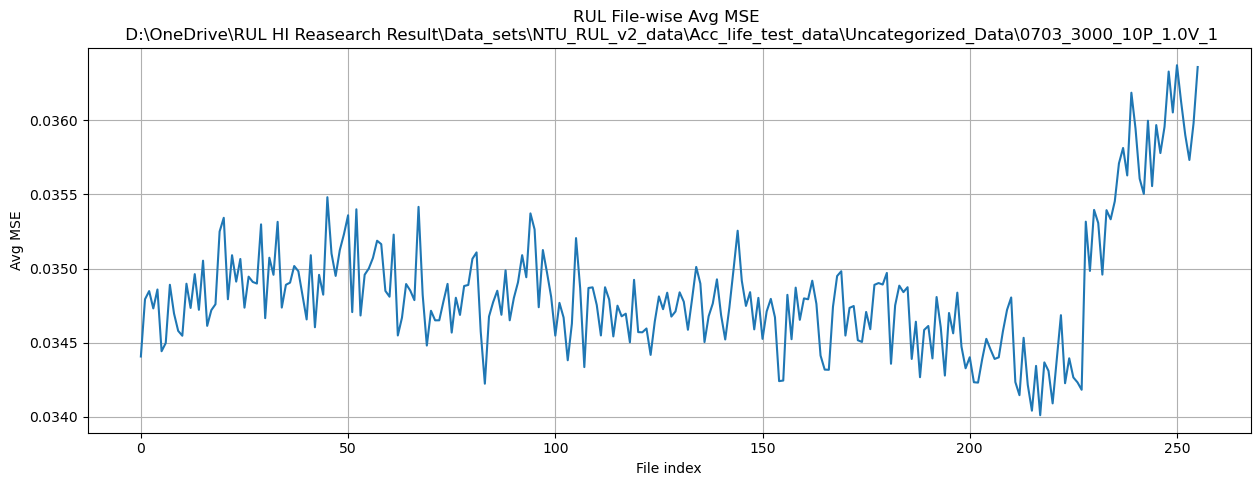

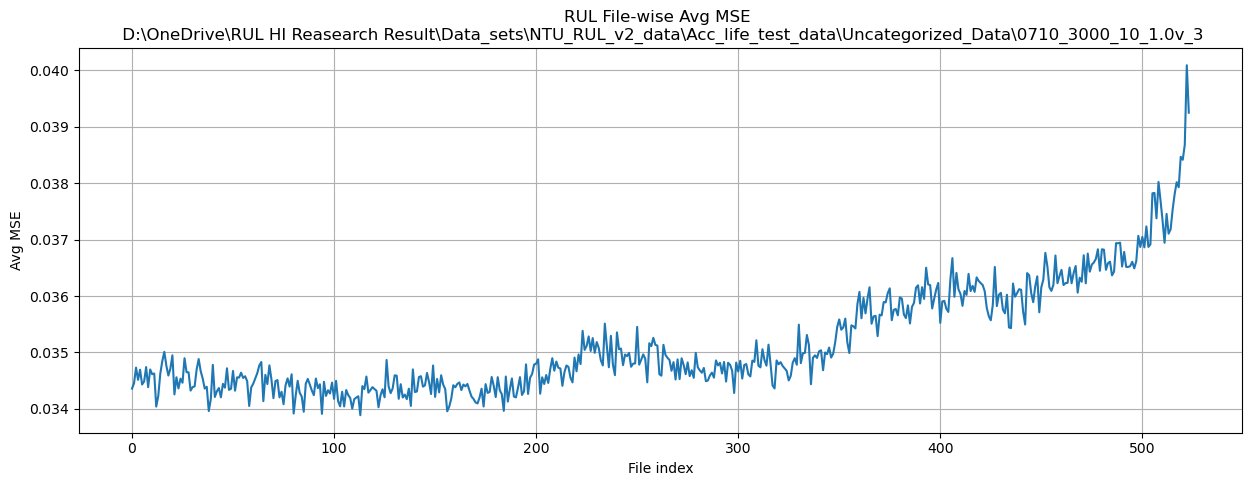

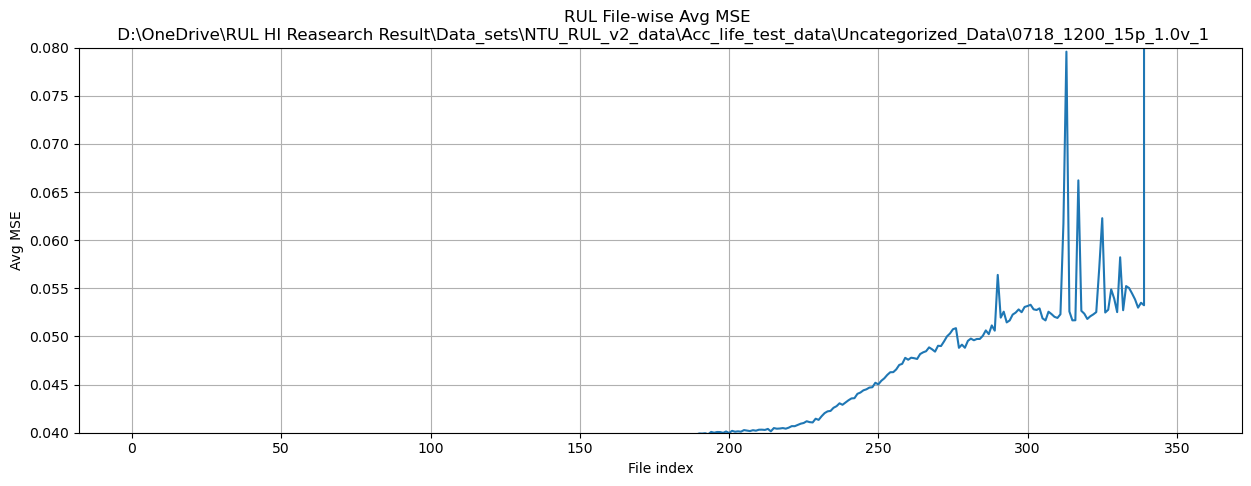

In [ ]:

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors1)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder1}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors2)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder2}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors3)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder3}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
plt.ylim(0.04, 0.08)
plt.grid()
plt.show()

